In [1]:
import matplotlib.pyplot as plt
import numpy as np
import phate
import random
import scipy as sp
import scprep
import sys

from sklearn.neighbors import NearestNeighbors


In [2]:
tree, branches = phate.tree.gen_dla(
    n_dim = 100, n_branch = 4, branch_length = 300, rand_multiplier = 2, seed=37, sigma = 5
)
print(tree.shape, branches.shape)

(1200, 100) (1200,)


In [3]:
data = tree
data.shape

(1200, 100)

In [4]:
phate_op = phate.PHATE()
data_ph = phate_op.fit_transform(tree)

Calculating PHATE...
  Running PHATE on 1200 observations and 100 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 0.22 seconds.
    Calculating affinities...
    Calculated affinities in 0.01 seconds.
  Calculated graph and diffusion operator in 0.24 seconds.
  Calculating optimal t...
    Automatically selected t = 11
  Calculated optimal t in 1.55 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.26 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 2.19 seconds.
Calculated PHATE in 4.29 seconds.


/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


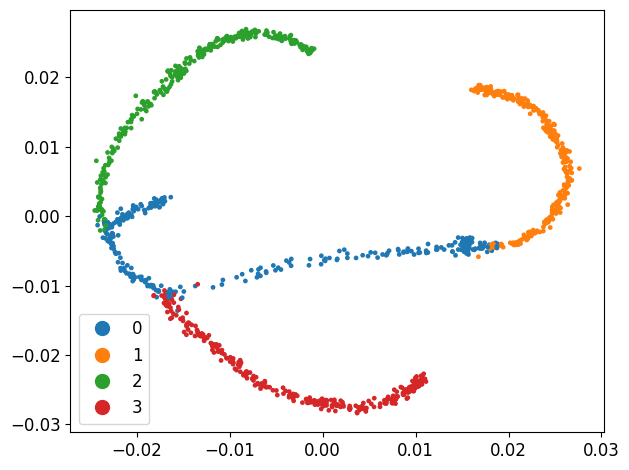

In [5]:
ax = scprep.plot.scatter2d(data_ph, c=branches)

In [6]:
import seaborn as sns

<Axes: >

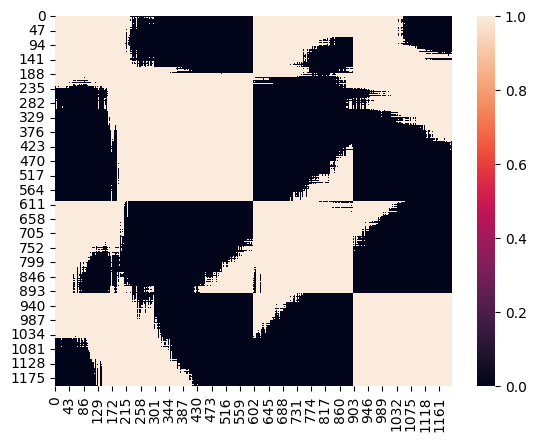

In [54]:
Z = data_ph
paird = sp.spatial.distance.cdist(Z, Z)
cutoff = np.percentile(paird, 50)
# cutoff = 0.04
t_rows, t_cols = np.where(paird >= cutoff)
f_rows, f_cols = np.where(paird < cutoff)
paird[t_rows, t_cols] = False
paird[f_rows, f_cols] = True 
sns.heatmap(paird)

In [247]:
import scipy as sp

def hacky_branch_point_prediction(
    emb,
    nearest_n=200,
    farest_n=5,    
    percentile=99,
    nearby_filter=None,
    clusters=None,
    toggle=True
):
    # pairwise distances in embedding space
    dist_mat = sp.spatial.distance.cdist(emb, emb)

    max_perc = 100
    cur_perc = max_perc - percentile

    # row is point we are looking at, cols are indicies of __furtherst__ neighbors first
    neigh_dist_sorted = dist_mat.argsort(axis=1)
    
    # row is point we are looking at, cols are indicies of __closest__ neighbors first
    neigh_dist_sorted = neigh_dist_sorted[:, ::-1]    
    if toggle:
        # NOTE: toggle = False --> farest (farest_n) of closest (nearest_n) neighbors
        # NOTE: toggle = True --> closest (farest_n) of farest (nearest_n) neighbors
        # we go back to taking the closest of the furthest data
        neigh_dist_sorted = neigh_dist_sorted[:, ::-1]    
    
    # n nearest neighbors
    near = neigh_dist_sorted[:, :nearest_n]
    
    # n nearest sorted to be furthest first
    near = near[:, ::-1]
    # n farest
    far = near[:, :farest_n]

    dist_mat_of_farest_nearby = dist_mat.take(far[far])
    mean_dist_of_farest_nearby = dist_mat_of_farest_nearby.mean(axis=1)
    stds = np.std(mean_dist_of_farest_nearby, axis=1)

    where_above = stds > np.percentile(stds, percentile)

    branch_point_guesses = np.where(where_above == True)[0]
    if nearby_filter is not None:
        keep = []
        ignore = []
        for ip, pnt in enumerate(branch_point_guesses):
            for ont in branch_point_guesses[ip+1:]:      
                
                if dist_mat[pnt, ont] < nearby_filter:
                    ignore.append(ont)
                    continue        
                    
                if pnt in keep:
                    continue
                if pnt in ignore:
                    continue
                keep.append(pnt)
        branch_point_guesses = keep


    if clusters is None:
        clusters = 'u'
    
    ax = scprep.plot.scatter2d(emb, c=clusters)    
    for i, node in enumerate(branch_point_guesses):
        coord = branch_point_guesses[i]
        ax.annotate(node, (emb[coord][0], emb[coord][1]), size=15)
    return branch_point_guesses


/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[106, 184, 230, 665, 760, 949]

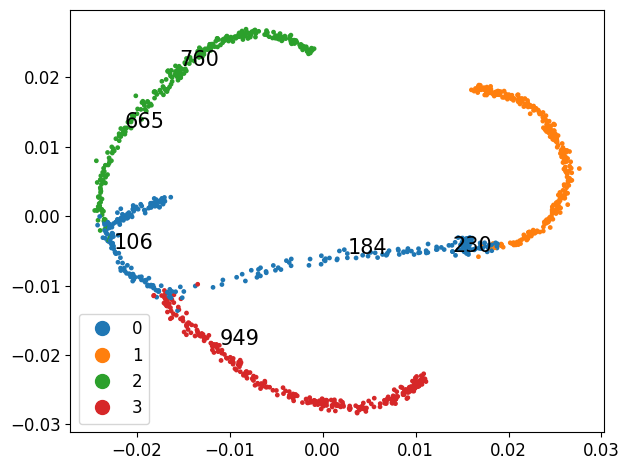

In [249]:
hacky_branch_point_prediction(
    data_ph, 100, 5, 99, 0.01, branches, toggle=True
)

In [228]:


sp.spatial.distance.cdist(data_ph[[242, 245]], data_ph[[242, 245]])

array([[0.        , 0.00089382],
       [0.00089382, 0.        ]])

In [129]:
hacky_branch_point_prediction(
    data_ph, 200, 5, 99, 0.35, branches
)

IndexError: arrays used as indices must be of integer (or boolean) type

In [162]:
ps[:, ::-1]

array([[   0,   29,   32, ...,  440,  453,  441],
       [   1,   34,   60, ...,  440,  453,  441],
       [   2,   59,   48, ...,  440,  453,  441],
       ...,
       [1197, 1194, 1195, ...,  787,  768,  823],
       [1198, 1163, 1173, ...,  768,  817,  823],
       [1199, 1193, 1180, ...,  787,  768,  823]])

<Axes: ylabel='Count'>

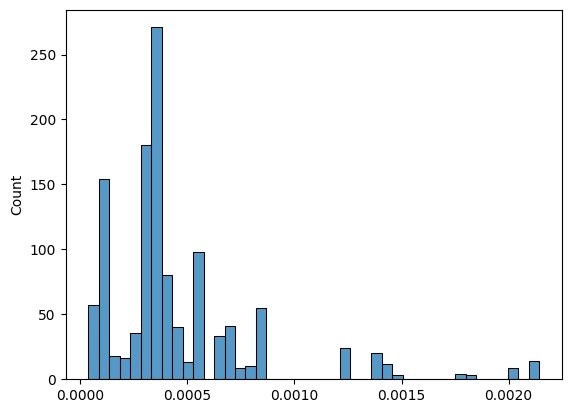

In [120]:
Z = data_ph
paird = sp.spatial.distance.cdist(Z, Z)

max_dist_n = 200
sub_dist_n = 5
__s = 1

ps = paird.argsort(axis=1)
Y = ps[:, :max_dist_n][:, ::-1][:, :sub_dist_n]

ps = paird.argsort(axis=1)[:, ::-1]
Y = ps[:, :max_dist_n][:, :][:, :sub_dist_n]

stds = np.std(paird.take(Y[Y]).mean(axis=1), axis=1)
# stds = np.std(paird.take(Y[Y]), axis=1)

bools = stds > np.percentile(stds, 100 - __s)
# bools = stds < np.percentile(stds, __s)
# bools = np.logical_not(bools)
zzz = np.where(bools == True)[0]
sns.histplot(stds)

In [125]:
ps

array([[ 441,  453,  440, ...,   32,   29,    0],
       [ 441,  453,  440, ...,   60,   34,    1],
       [ 441,  453,  440, ...,   48,   59,    2],
       ...,
       [ 823,  768,  787, ..., 1195, 1194, 1197],
       [ 823,  817,  768, ..., 1173, 1163, 1198],
       [ 823,  768,  787, ..., 1180, 1193, 1199]])

<Axes: >

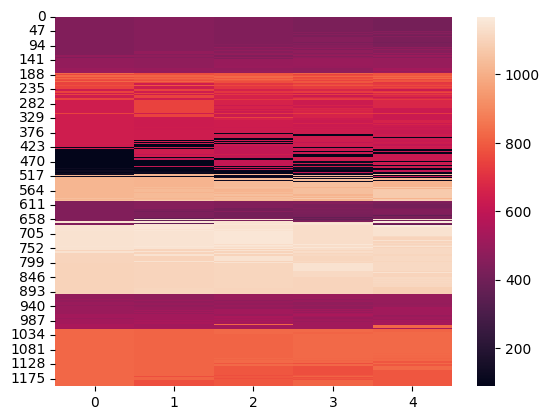

In [121]:
sns.heatmap(Y)

<Axes: >

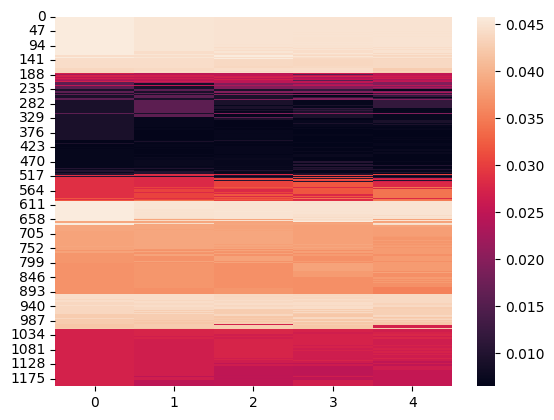

In [122]:
sns.heatmap(paird.take(Y))

/Users/sumner/miniforge3/envs/spot-mark-gene/lib/python3.10/site-packages/scprep/plot/utils.py:104: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


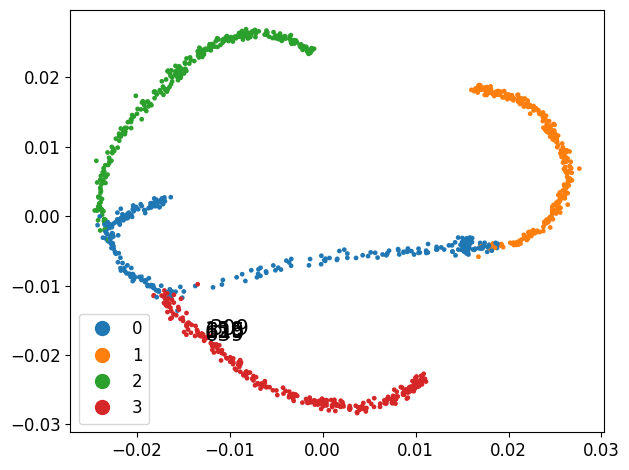

In [123]:
ax = scprep.plot.scatter2d(data_ph, c=branches)
# zzz = [611, 893, 1034, 129,940, 0]
# zzz = found
# zzz = np.unique(Y.mean(axis=1).round().astype(int))
for ___I, txt in enumerate(keep):
  coord = zzz[___I]
  ax.annotate(txt, (data_ph[coord][0], data_ph[coord][1]), size=15)

In [117]:
keep = []
for ip, pnt in enumerate(zzz):
    for ont in zzz[ip:]:
        if paird[pnt, ont] < 0.03:
            continue
        if pnt in keep:
            continue
        keep.append(pnt)


In [118]:
keep, zzz

([159, 309, 315, 626, 639],
 array([ 159,  170,  309,  315,  626,  639,  938, 1182, 1191, 1193, 1195,
        1197]))

In [100]:
paird.take(Y[zzz])

array([[0.02605448, 0.01973349, 0.02596738, 0.02587829, 0.00601335],
       [0.02464234, 0.01096256, 0.01097639, 0.01116401, 0.02395156],
       [0.02704555, 0.04395024, 0.04417258, 0.02742551, 0.02740155],
       [0.02704555, 0.04395024, 0.04417258, 0.02742551, 0.02740155],
       [0.01498106, 0.01489283, 0.01505319, 0.01459056, 0.01441028],
       [0.01489283, 0.00853029, 0.01505319, 0.01459056, 0.01441028],
       [0.02960542, 0.00922774, 0.02964771, 0.01435266, 0.01514889],
       [0.02576526, 0.02701749, 0.0271385 , 0.02573142, 0.02996262],
       [0.02576526, 0.02701749, 0.02996262, 0.02573142, 0.0271385 ],
       [0.02742551, 0.02573142, 0.02701749, 0.0271385 , 0.02996262],
       [0.02576729, 0.02776837, 0.02532052, 0.02972061, 0.02740155],
       [0.02740155, 0.02532052, 0.02803184, 0.02779576, 0.02742551]])

In [106]:
paird[zzz][:, zzz].round(5)

array([[0.     , 0.00937, 0.0316 , 0.03155, 0.02011, 0.01964, 0.00741,
        0.02615, 0.02603, 0.02634, 0.02587, 0.02578],
       [0.00937, 0.     , 0.02268, 0.02262, 0.02375, 0.0232 , 0.01571,
        0.02236, 0.02224, 0.02256, 0.02184, 0.02188],
       [0.0316 , 0.02268, 0.     , 0.00011, 0.04427, 0.04372, 0.03624,
        0.02101, 0.02099, 0.0211 , 0.02025, 0.02062],
       [0.03155, 0.02262, 0.00011, 0.     , 0.04418, 0.04363, 0.0362 ,
        0.02105, 0.02103, 0.02115, 0.0203 , 0.02066],
       [0.02011, 0.02375, 0.04427, 0.04418, 0.     , 0.00055, 0.02469,
        0.04537, 0.04525, 0.04557, 0.04497, 0.04494],
       [0.01964, 0.0232 , 0.04372, 0.04363, 0.00055, 0.     , 0.02432,
        0.04485, 0.04472, 0.04505, 0.04444, 0.04442],
       [0.00741, 0.01571, 0.03624, 0.0362 , 0.02469, 0.02432, 0.     ,
        0.02622, 0.0261 , 0.02638, 0.02616, 0.02596],
       [0.02615, 0.02236, 0.02101, 0.02105, 0.04537, 0.04485, 0.02622,
        0.     , 0.00013, 0.0002 , 0.00078, 0.00052],
